In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

class ResidualBlock(nn.Module):
    """
    A residual block as defined by He et al.
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super(ResidualBlock, self).__init__()
        self.conv_res1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, stride=stride, bias=False)
        self.conv_res1_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
        self.conv_res2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                                   padding=padding, bias=False)
        self.conv_res2_bn = nn.BatchNorm2d(num_features=out_channels, momentum=0.9)

        if stride != 1:
            # in case stride is not set to 1, we need to downsample the residual so that
            # the dimensions are the same when we add them together
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels, momentum=0.9)
            )
        else:
            self.downsample = None

        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x

        out = self.relu(self.conv_res1_bn(self.conv_res1(x)))
        out = self.conv_res2_bn(self.conv_res2(out))

        if self.downsample is not None:
            residual = self.downsample(residual)

        out = self.relu(out)
        out = out + residual
        return out


class Net(nn.Module):
    """
    A Residual network.
    """
    def __init__(self):
        super(Net, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True)

    def forward(self, x):
        out = self.conv(x)
        out = out.view(-1, out.shape[1] * out.shape[2] * out.shape[3])
        out = self.fc(out)
        return out

In [2]:
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = Net().to(device)
summary(model, (3,32,32))


Using cuda device
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
    ResidualBlock-14 

In [3]:
# batch_size = 128
batch_size = 256
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(len(trainloader))
for X,y in trainloader:
  print(X.shape)
  print(y.shape)
  print(X[0])
  break

196
torch.Size([256, 3, 32, 32])
torch.Size([256])
tensor([[[-2.4291, -2.4291, -2.4291,  ...,  0.4787,  0.4399,  0.2461],
         [-2.4291, -2.4291, -2.4291,  ...,  0.5368,  0.3624, -0.1416],
         [-2.4291, -2.4291, -2.4291,  ..., -0.1416, -0.6650, -1.0527],
         ...,
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291],
         [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],

        [[-2.4183, -2.4183, -2.4183,  ...,  0.5908,  0.5318,  0.3154],
         [-2.4183, -2.4183, -2.4183,  ...,  0.6891,  0.4728, -0.1369],
         [-2.4183, -2.4183, -2.4183,  ..., -0.1369, -0.6876, -1.1399],
         ...,
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183],
         [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],

        [[-2.2214, -2.2214, -2.2214,  ...,  0.9393,  0.7832,  0.2

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [6]:
train_acc = []
test_acc = []

In [7]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  correct = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad(set_to_none=True) # set_to_none=False
    loss.backward()  
    optimizer.step()  # update the parameters in neural network

    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    if batch % 100 == 0:
      loss, current = loss.item(), batch*len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
  train_acc.append(correct/size)   

In [8]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  test_acc.append(correct)
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")

In [9]:
epochs = 100
for i in range(epochs):
  print(f"Epoch {i+1}\n------------------------")
  train(trainloader, model, loss_fn, optimizer)
  test(testloader, model, loss_fn)
print("Done!")

Epoch 1
------------------------
loss: 2.846396 [    0/50000]
loss: 1.376461 [25600/50000]
Test Error: 
 Accuracy: 62.0%, Avg loss: 1.047652

Epoch 2
------------------------
loss: 1.062182 [    0/50000]
loss: 0.974818 [25600/50000]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.781698

Epoch 3
------------------------
loss: 0.748443 [    0/50000]
loss: 0.807550 [25600/50000]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.600069

Epoch 4
------------------------
loss: 0.668550 [    0/50000]
loss: 0.594981 [25600/50000]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.567921

Epoch 5
------------------------
loss: 0.557279 [    0/50000]
loss: 0.622892 [25600/50000]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.521219

Epoch 6
------------------------
loss: 0.409506 [    0/50000]
loss: 0.553759 [25600/50000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.501141

Epoch 7
------------------------
loss: 0.326121 [    0/50000]
loss: 0.427100 [25600/50000]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.458889

Epoch 

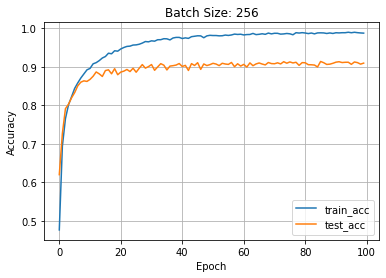

In [10]:
import matplotlib.pyplot as plt
x = [i for i in range(epochs)]
plt.plot(x,train_acc, label = 'train_acc')
plt.plot(x,test_acc, label = 'test_acc')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.title('Batch Size: 128')
plt.title('Batch Size: 256')
plt.grid()
plt.show()